In [37]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1329)

In [38]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

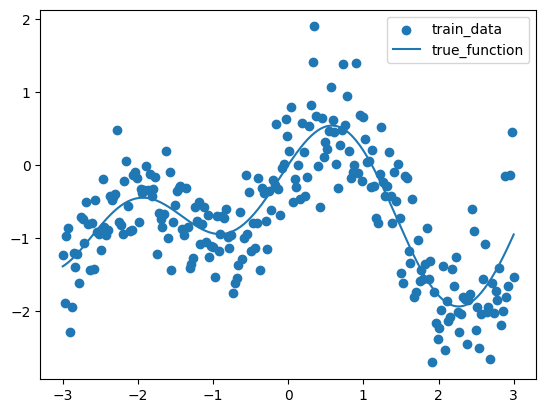

In [39]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [40]:
lamb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

In [41]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [42]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

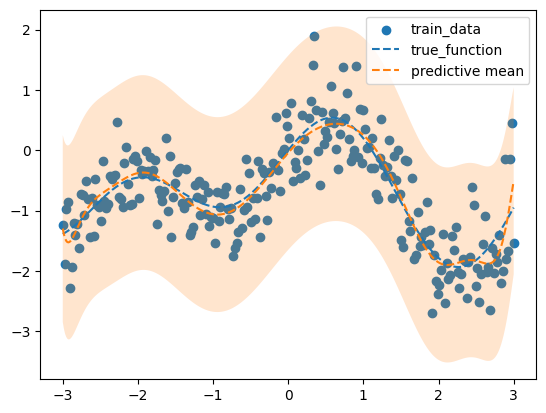

In [43]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [68]:


def log_evidence(lamb, X, y, alpha):
    '''
    Тут надо написать расчет log-evidence, через формулу, которая была в лекции
    Далее взять какой-то набор лямбд (например np.logspace(-6, 3, 160)) и оценить для каждой эту функцию
    Получится лучшая лябмда
    Вывести график log-evidence vs lambda + графики, чтобы визуально сравнить предсказания базовой модели и модели с лучшей лямбдой
    '''


    #C = σ**2 * I + τ ** 2 * X * X.T
    #-0.5 (n * log(2π) + log det C + y.T * (C**-1) * y)
    
    n = X.shape[0]
    I = np.eye(n)

    sigma2 = 1.0 / alpha

#    lamb = sigma2/ tau2

    tau2 = sigma2/lamb

    assert tau2 >= 0 and sigma2 >= 0

    C = sigma2 * I + tau2 * (X @ X.T)
    #print(X @ X.T)
    

    b = np.log(np.linalg.det(C))
    return -0.5 * (n * np.log(2*np.pi) + b + (y.T @ np.linalg.inv(C) @ y))


xl = []
yl = []
for lamb in np.logspace(-1, 2, 4000):
    le = log_evidence(lamb, X, y, alpha)
    if not np.isnan(le):
        yl.append(le)
        xl.append(lamb)


/tmp/ipykernel_122301/3893353255.py:28: RuntimeWarning: invalid value encountered in log
  b = np.log(np.linalg.det(C))


max lambda 0.1705328114401524


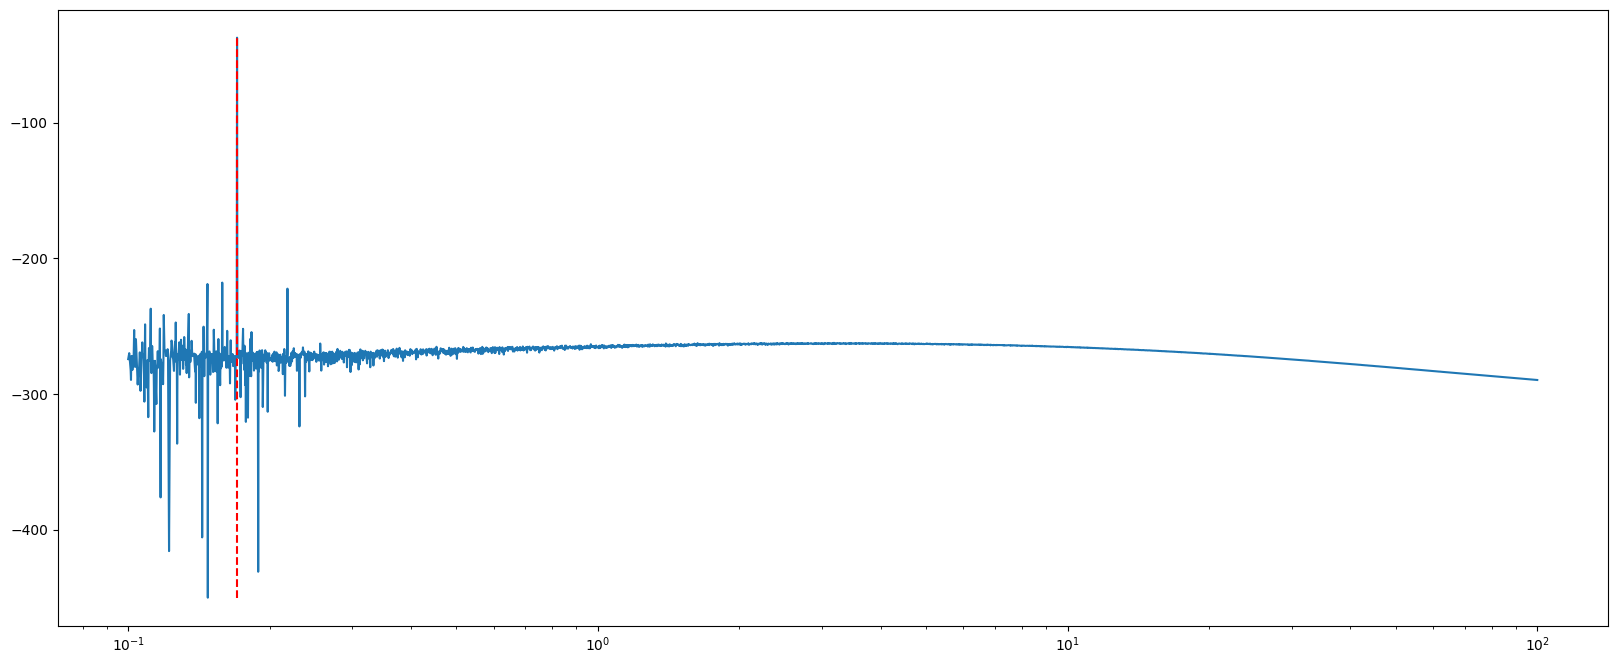

In [70]:
max_log = np.argmax(yl)
max_lambda = xl[max_log]

print('max lambda', max_lambda)

plt.figure(figsize=(20, 8))
plt.xscale('log')
plt.plot(xl, yl)

plt.vlines([max_lambda], np.min(yl), np.max(yl), colors='r', linestyles='dashed')

Эти выбросы выглядят как выбросы из-за деления на околонулевые числа. И если смотреть на сглаженный график то максимум где то от 1 до 10. Запустим еще раз в этом диапазоне

In [79]:
xl = []
yl = []
for lamb in np.linspace(0.1, 10, 1000):
    le = log_evidence(lamb, X, y, alpha)
    if not np.isnan(le):
        yl.append(le)
        xl.append(lamb)


/tmp/ipykernel_122301/3893353255.py:28: RuntimeWarning: invalid value encountered in log
  b = np.log(np.linalg.det(C))


max lambda 3.0927927927927934


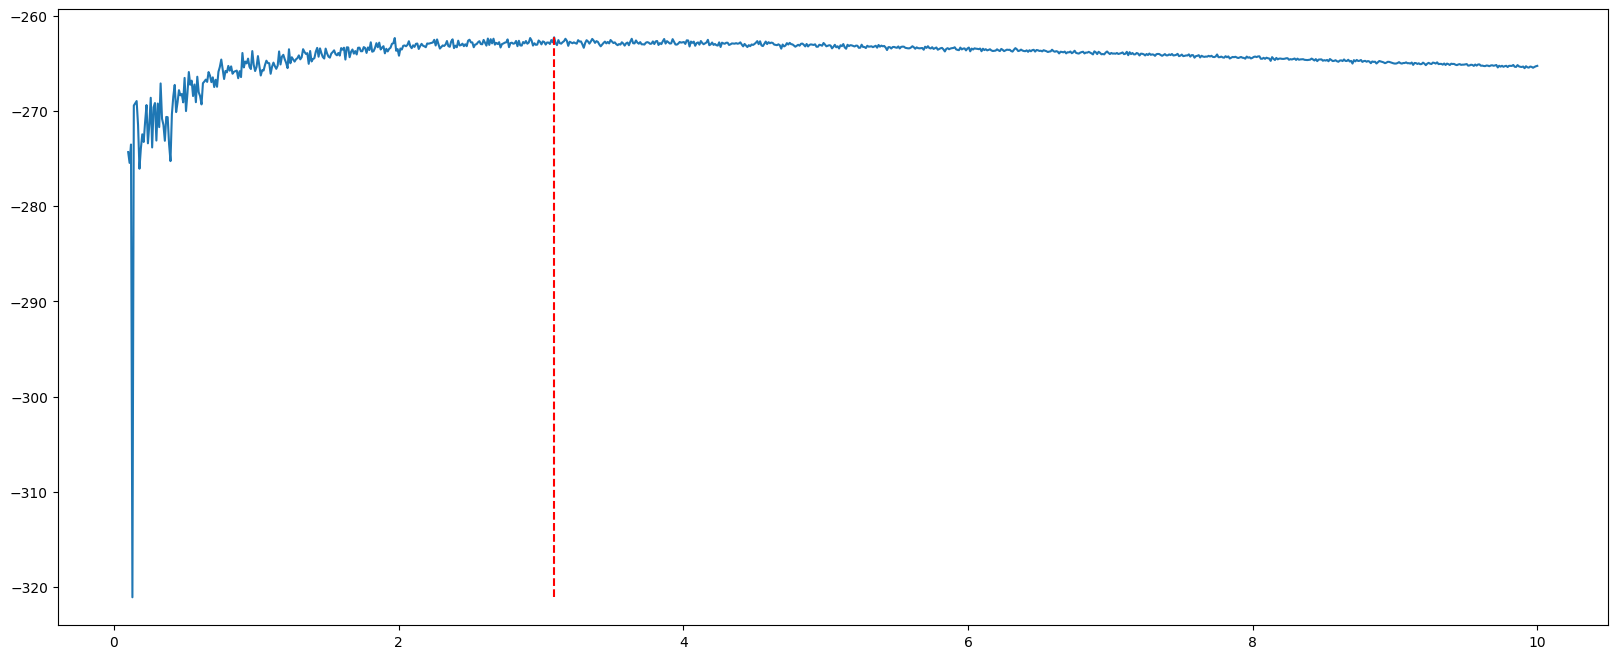

In [80]:
max_log = np.argmax(yl)
max_lambda = xl[max_log]

print('max lambda', max_lambda)

plt.figure(figsize=(20, 8))
#plt.xscale('log')
plt.plot(xl, yl)

plt.vlines([max_lambda], np.min(yl), np.max(yl), colors='r', linestyles='dashed')

## Модель с лучшей лямбдой $\lambda=3.0927927927927934$

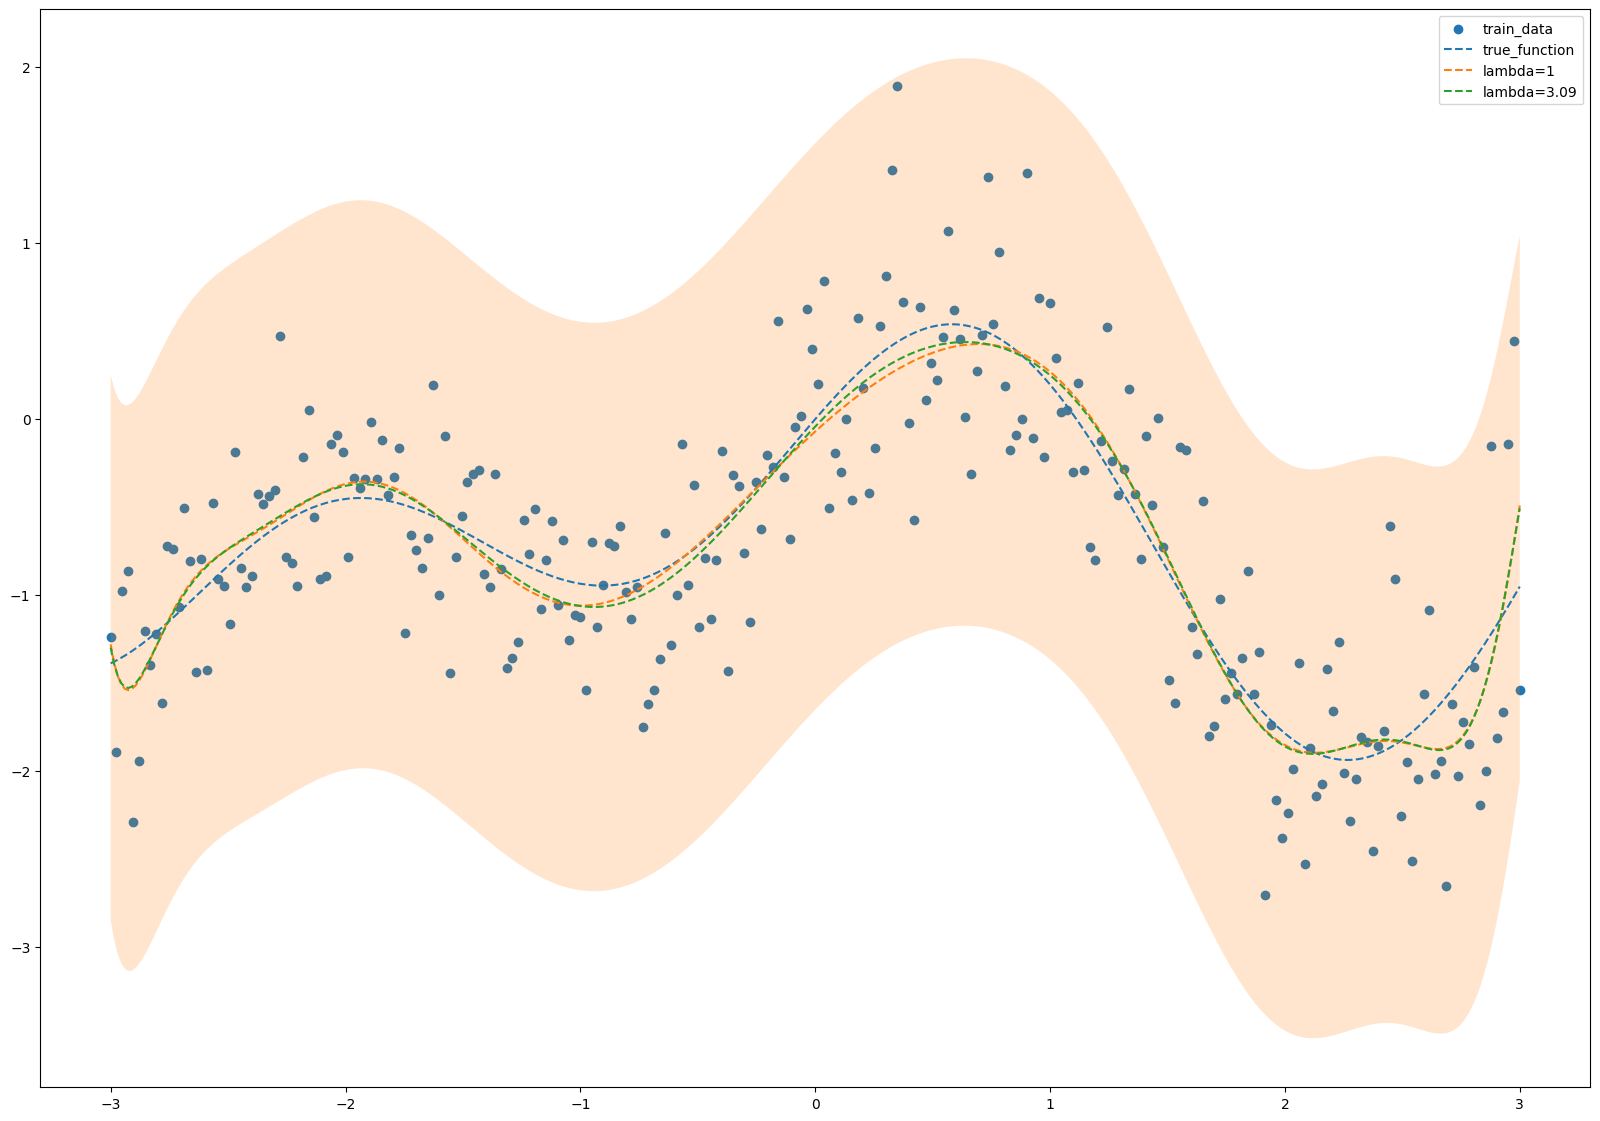

In [85]:
def model_pred(lamb):
    alpha = 1.0 / (sigma ** 2)

    M = X.shape[1]
    posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

    posterior_cov = np.linalg.inv(posterior_cov_inv)
    mean = alpha * posterior_cov @ (X.T @ y)

    x_new = np.linspace(-3, 3, 400)
    X_new = make_poly_features(x_new, degree)

    mean_pred = X_new @ mean
    var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
    std_pred = np.sqrt(var_pred)
    return x_new, mean_pred

old_x, old_mean = model_pred(3.0927927927927934)
new_x, new_mean = model_pred(1)
plt.figure(figsize=(20, 14))
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(old_x, old_mean, linestyle='--', label='lambda=1')
plt.plot(new_x, new_mean, linestyle='--', label='lambda=3.09')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()


## Ну как будто не хуже но и не лучше визуально